In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohabmansour","key":"5d983317f1b88ef2a68c1e0342aafb78"}'}

In [ ]:
import os
import zipfile

# Create .kaggle folder and move the JSON file there
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json




In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:21<00:00, 271MB/s]
100% 2.29G/2.29G [00:21<00:00, 117MB/s]


In [ ]:
import zipfile

zip_path = "/content/chest-xray-pneumonia.zip"
extract_to = "/content/xray"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete!")

✅ Extraction complete!


##Lybariry

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import kagglehub
import os
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping ,ReduceLROnPlateau

##Load data

In [ ]:
# Define directories
train_dir = '/content/xray/chest_xray/chest_xray/train'
val_dir = '/content/xray/chest_xray/chest_xray/val'
test_dir = '/content/xray/chest_xray/chest_xray/test'

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# To get X and y arrays from a generator (if needed):

X_train, y_train = next(train_generator)
X_val, y_val = next(val_generator)
X_test, y_test = next(test_generator)

print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


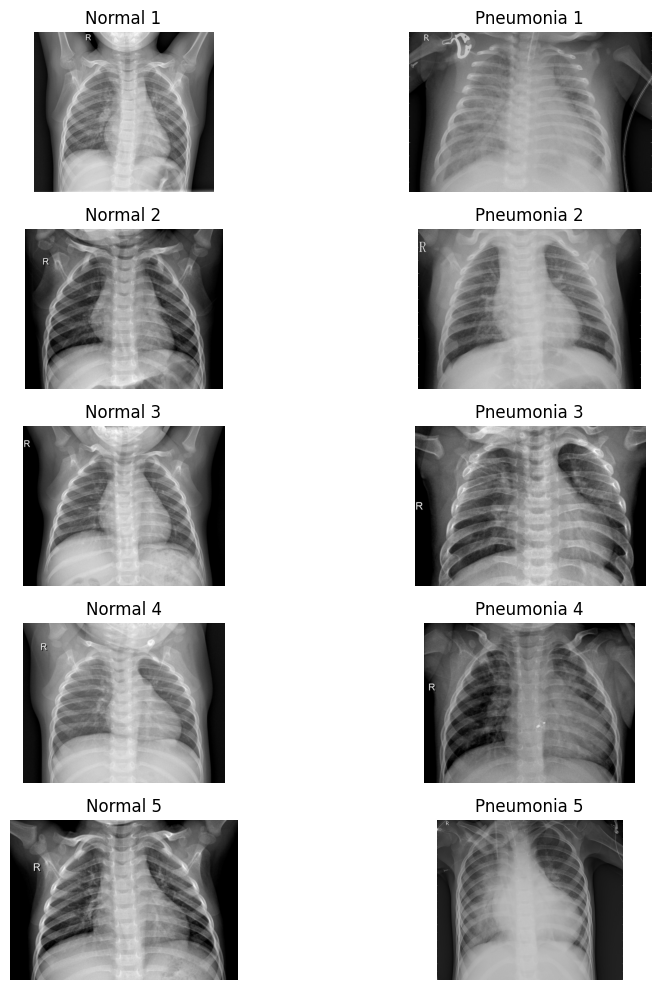

In [ ]:
normal_path = '/content/xray/chest_xray/chest_xray/train/NORMAL'
pneumonia_path = '/content/xray/chest_xray/chest_xray/train/PNEUMONIA'

image_extensions = ['.jpg', '.jpeg', '.png']

# Filter to include only image files
normal_images = [f for f in sorted(os.listdir(normal_path)) if f.lower().endswith(tuple(image_extensions))]
pneumonia_images = [f for f in sorted(os.listdir(pneumonia_path)) if f.lower().endswith(tuple(image_extensions))]

# Pick the first 5 images from each class
normal_images = normal_images[:5]
pneumonia_images = pneumonia_images[:5]

# Plot the images side by side
plt.figure(figsize=(10, 10))
for i in range(5):
    # Normal image
    img_normal = mpimg.imread(os.path.join(normal_path, normal_images[i]))
    plt.subplot(5, 2, i*2 + 1)
    plt.imshow(img_normal, cmap='gray')
    plt.title(f'Normal {i+1}')
    plt.axis('off')

    # Pneumonia image
    img_pneumonia = mpimg.imread(os.path.join(pneumonia_path, pneumonia_images[i]))
    plt.subplot(5, 2, i*2 + 2)
    plt.imshow(img_pneumonia, cmap='gray')
    plt.title(f'Pneumonia {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

##Preprocessing images

In [ ]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0,1]
    rotation_range=20,         # Rotate images randomly within 20 degrees
    width_shift_range=0.1,     # Randomly shift images horizontally (10%)
    height_shift_range=0.1,    # Randomly shift images vertically (10%)
    shear_range=0.1,           # Shear transformation
    zoom_range=0.1,            # Zoom in/out randomly
    horizontal_flip=True,      # Flip images horizontally
    fill_mode='nearest'        # Fill missing pixels after transformations
)

# Validation and test data generator (only scaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)


# **Training 3 Models**

##Model EfficientNetB0

In [ ]:
# Build model function
def build_efficientnet_model(input_shape=(224,224,3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze some layers for better learning
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Added dense layer
    x = Dropout(0.5)(x)  # Increased dropout
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=preds)
    return model

model = build_efficientnet_model()

# Now call summary outside
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 4,168,541 (15.90 MB)

 Non-trainable params: 209,223 (817.28 KB)

##fit the model

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Optimizers to test with adjusted learning rates
optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=1e-4),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    'SGD': tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
}

In [ ]:
results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{'='*50}\nTraining with {opt_name} optimizer\n{'='*50}")

    model = build_efficientnet_model()
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Store results
    results[opt_name] = {
        'history': history,
        'val_accuracy': max(history.history['val_accuracy'])
    }

    print(f"\n{opt_name} achieved max validation accuracy: {results[opt_name]['val_accuracy']:.4f}")

# Find and display the best optimizer
best_optimizer = max(results.items(), key=lambda x: x[1]['val_accuracy'])
print(f"\n{'='*50}\nBest optimizer: {best_optimizer[0]} with val_accuracy {best_optimizer[1]['val_accuracy']:.4f}\n{'='*50}")

# Evaluate on test set with best optimizer
print("\nEvaluating best model on test set...")
best_model = build_efficientnet_model()
best_model.compile(
    optimizer=optimizers[best_optimizer[0]],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train final model with combined train+val data (optional)
# Then evaluate on test set
test_results = best_model.evaluate(test_generator)
print(f"\nTest accuracy: {test_results[1]:.4f}")


Training with Adam optimizer


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 370ms/step - accuracy: 0.8038 - loss: 0.4158 - val_accuracy: 0.5625 - val_loss: 0.6894 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 307ms/step - accuracy: 0.9041 - loss: 0.2374 - val_accuracy: 0.5000 - val_loss: 1.4859 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 306ms/step - accuracy: 0.9121 - loss: 0.2149 - val_accuracy: 0.5000 - val_loss: 1.1449 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 304ms/step - accuracy: 0.9235 - loss: 0.1840 - val_accuracy: 0.5625 - val_loss: 0.8269 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9292 - loss: 0.1790 - val_accuracy: 0.7500 - val_loss: 0.6635 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 308ms/step - accuracy: 0.9315 - loss: 0.1547 - val_accuracy: 0.6250 - val_loss: 1.0704 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 3

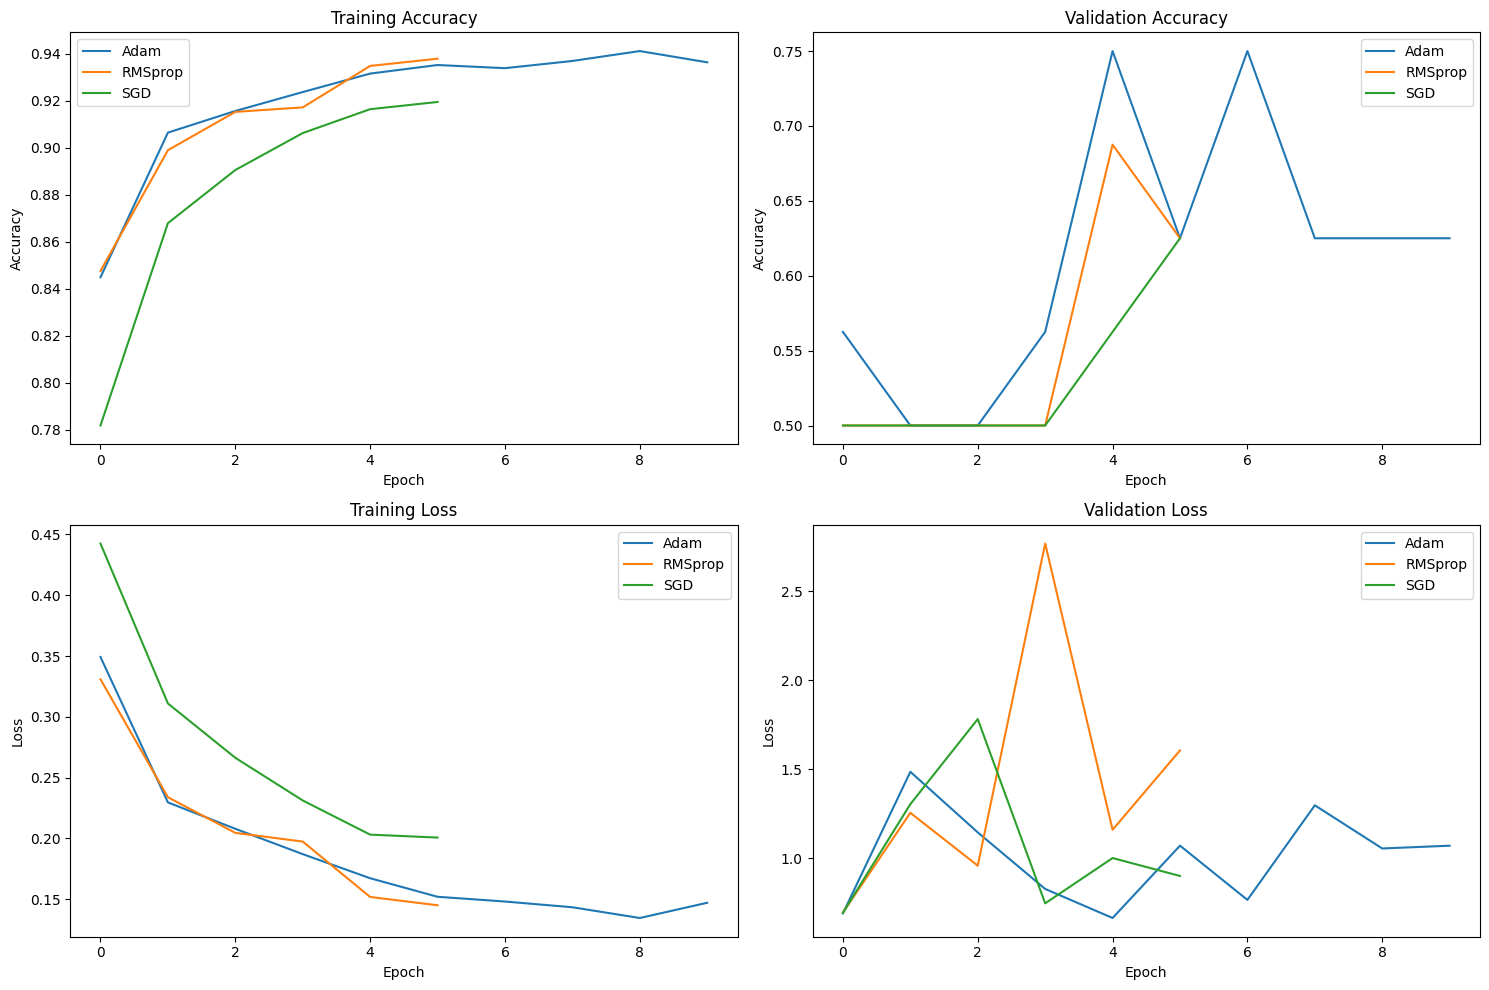

In [ ]:

plt.figure(figsize=(15, 10))

# Plot accuracy and validation accuracy for each optimizer
for i, (opt_name, result) in enumerate(results.items()):
    history = result['history']

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label=f'{opt_name}')
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['val_accuracy'], label=f'{opt_name}')
    plt.title('Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label=f'{opt_name}')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_loss'], label=f'{opt_name}')
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
plt.show()



#Model Resent

In [ ]:


# Build model function
def build_resnet_model(input_shape=(224,224,3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze some layers for better learning
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Added dense layer
    x = Dropout(0.5)(x)  # Increased dropout
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=preds)
    return model

model = build_resnet_model()

# Now call summary outside
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

##fit model

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Optimizers to test
optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=1e-4),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    'SGD': tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
}

In [ ]:
results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{'='*50}\nTraining with {opt_name} optimizer\n{'='*50}")

    model = build_resnet_model()
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Store results
    results[opt_name] = {
        'history': history,
        'val_accuracy': max(history.history['val_accuracy'])
    }

    print(f"\n{opt_name} achieved max validation accuracy: {results[opt_name]['val_accuracy']:.4f}")

# Find and display the best optimizer
best_optimizer = max(results.items(), key=lambda x: x[1]['val_accuracy'])
print(f"\n{'='*50}\nBest optimizer: {best_optimizer[0]} with val_accuracy {best_optimizer[1]['val_accuracy']:.4f}\n{'='*50}")

# Evaluate on test set with best optimizer
print("\nEvaluating best model on test set...")
best_model = build_resnet_model()
best_model.compile(
    optimizer=optimizers[best_optimizer[0]],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train final model with combined train+val data (optional)
# Then evaluate on test set
test_results = best_model.evaluate(test_generator)
print(f"\nTest accuracy: {test_results[1]:.4f}")


Training with Adam optimizer
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 364ms/step - accuracy: 0.8992 - loss: 0.2302 - val_accuracy: 0.5000 - val_loss: 6.3212 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 329ms/step - accuracy: 0.9558 - loss: 0.1171 - val_accuracy: 0.5000 - val_loss: 8.4976 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 333ms/step - accuracy: 0.9636 - loss: 0.1008 - val_accuracy: 0.5000 - val_loss: 7.2509 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 339ms/step - accuracy: 0.9683 - loss: 0.0801 - val_accuracy: 0.5625 - val_loss: 3.5980 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 332ms/step - accuracy: 0.9744 - loss: 0.0686 - val_accuracy: 0.5000 - val_loss: 28.4570 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.9743 - loss: 0.0678 - val_accuracy: 0.5000 - val_loss: 19.2600 - learning_rate: 1.0000e-04
Epoch 7/10
163

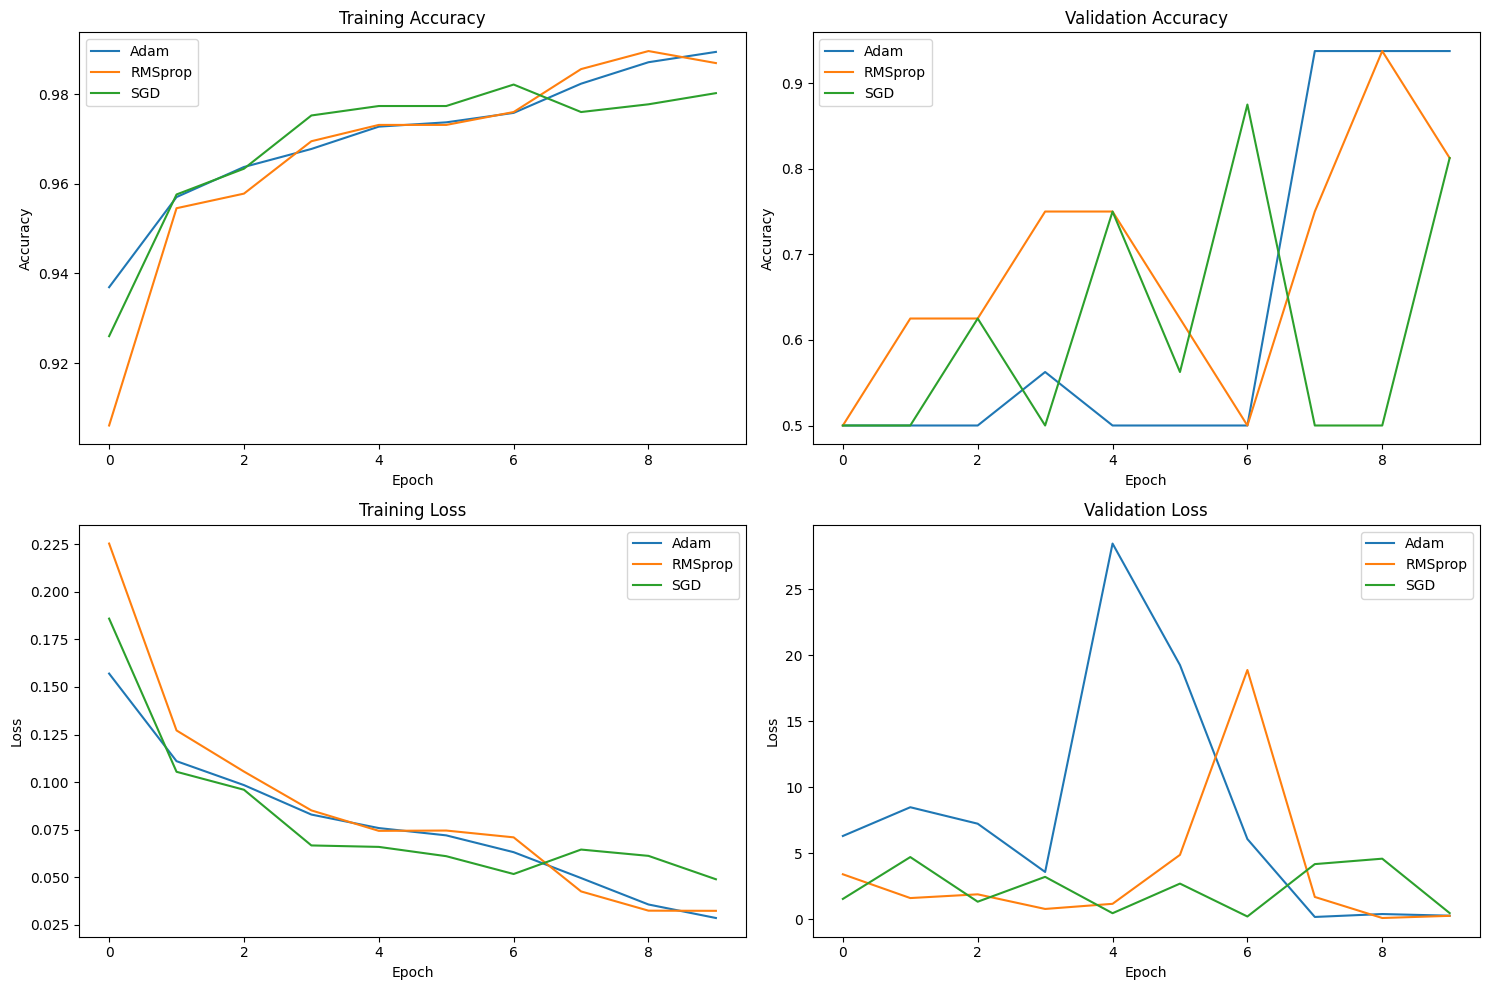

In [ ]:

plt.figure(figsize=(15, 10))

# Plot accuracy and validation accuracy for each optimizer
for i, (opt_name, result) in enumerate(results.items()):
    history = result['history']

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label=f'{opt_name}')
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['val_accuracy'], label=f'{opt_name}')
    plt.title('Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label=f'{opt_name}')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_loss'], label=f'{opt_name}')
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
plt.show()

#Model MobileNet

In [ ]:




# Build model function
def build_mobilenet_model(input_shape=(224,224,3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze some layers for better learning
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Added dense layer
    x = Dropout(0.5)(x)  # Increased dropout
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=preds)
    return model

model = build_mobilenet_model()

# Now call summary outside
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 2,189,633 (8.35 MB)

 Non-trainable params: 396,544 (1.51 MB)

##fit model

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Optimizers to test
optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=1e-4),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    'SGD': tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
}

In [ ]:
results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{'='*50}\nTraining with {opt_name} optimizer\n{'='*50}")

    model = build_mobilenet_model()
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Store results
    results[opt_name] = {
        'history': history,
        'val_accuracy': max(history.history['val_accuracy'])
    }

    print(f"\n{opt_name} achieved max validation accuracy: {results[opt_name]['val_accuracy']:.4f}")

# Find and display the best optimizer
best_optimizer = max(results.items(), key=lambda x: x[1]['val_accuracy'])
print(f"\n{'='*50}\nBest optimizer: {best_optimizer[0]} with val_accuracy {best_optimizer[1]['val_accuracy']:.4f}\n{'='*50}")

# Evaluate on test set with best optimizer
print("\nEvaluating best model on test set...")
best_model = build_mobilenet_model()
best_model.compile(
    optimizer=optimizers[best_optimizer[0]],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train final model with combined train+val data (optional)
# Then evaluate on test set
test_results = best_model.evaluate(test_generator)
print(f"\nTest accuracy: {test_results[1]:.4f}")


Training with Adam optimizer
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 323ms/step - accuracy: 0.8864 - loss: 0.2273 - val_accuracy: 0.5000 - val_loss: 4.9598 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 299ms/step - accuracy: 0.9859 - loss: 0.0370 - val_accuracy: 0.5000 - val_loss: 4.4736 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.9970 - loss: 0.0130 - val_accuracy: 0.5000 - val_loss: 3.3652 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.5000 - val_loss: 4.4505 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 301ms/step - accuracy: 0.9991 - loss: 0.0044 - val_accuracy: 0.5000 - val_loss: 3.4953 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.5000 - val_loss: 3.1556 - learning_rate: 1.0000e-04

Adam achieved m

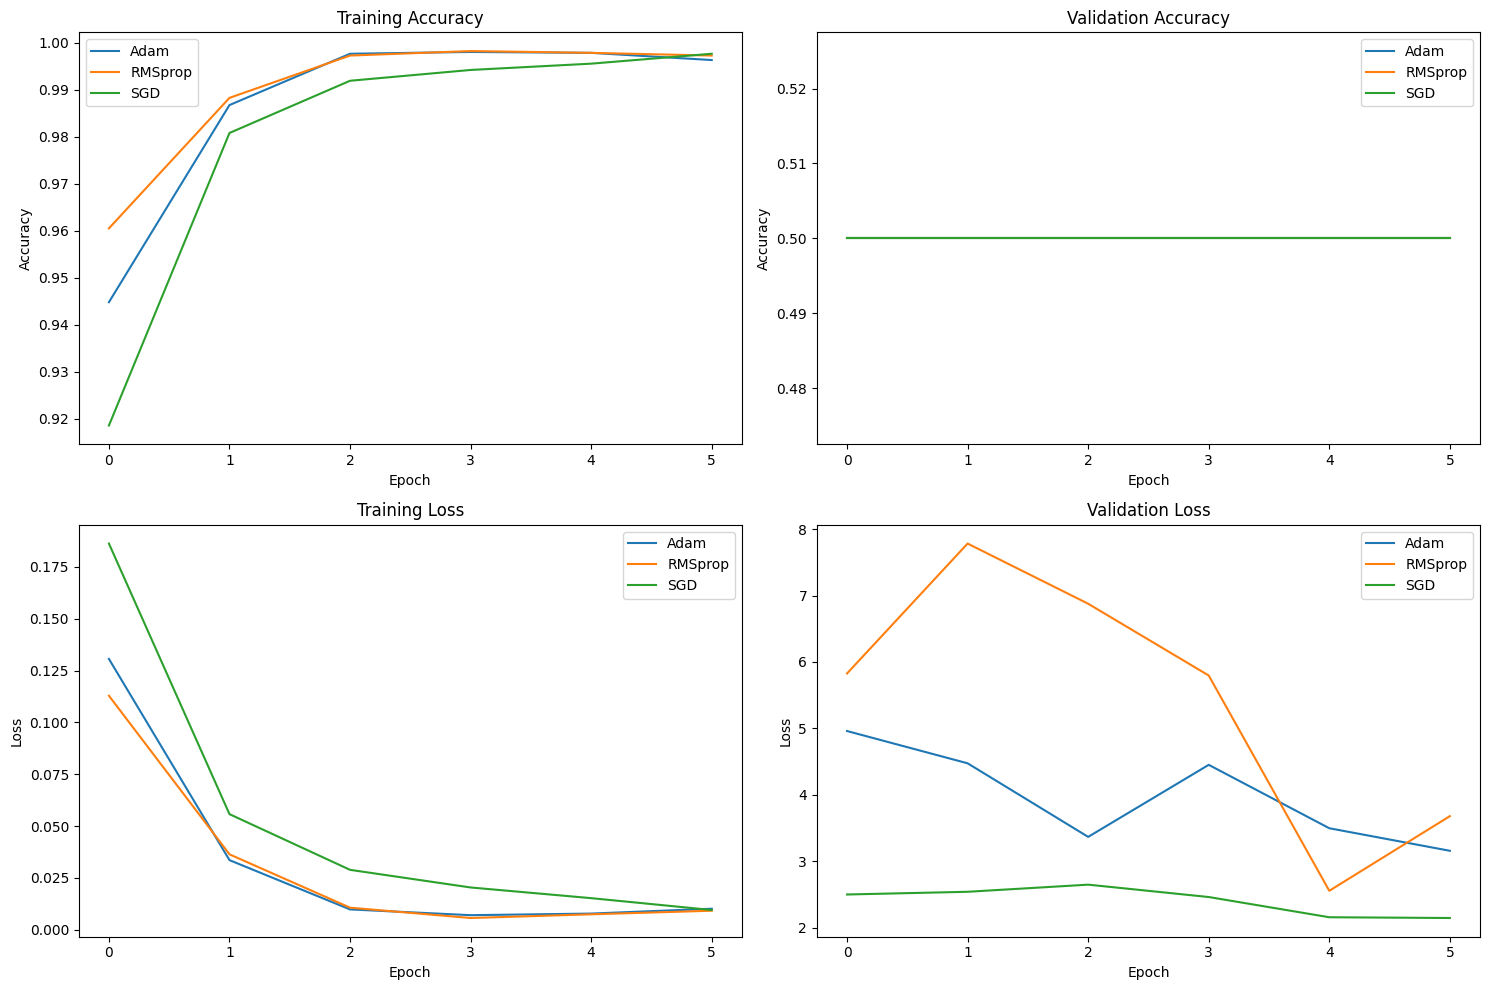

In [ ]:

plt.figure(figsize=(15, 10))

# Plot accuracy and validation accuracy for each optimizer
for i, (opt_name, result) in enumerate(results.items()):
    history = result['history']

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label=f'{opt_name}')
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['val_accuracy'], label=f'{opt_name}')
    plt.title('Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label=f'{opt_name}')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_loss'], label=f'{opt_name}')
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# Get ground truth labels and predictions
test_generator.reset()  # Ensure generator index is at 0
y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

num_classes = len(np.unique(y_true))

if num_classes <= 10:
    # Confusion matrix and classification report
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
else:
    # Class-wise F1-score
    f1_scores = f1_score(y_true, y_pred, average=None)
    for i, score in enumerate(f1_scores):
        print(f"Class {i} F1-score: {score:.4f}")
    print("\nMacro average F1-score:", f1_score(y_true, y_pred, average='macro'))

#F1

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step


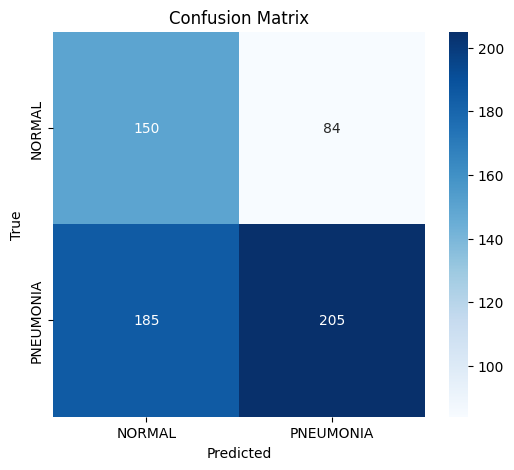


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.45      0.64      0.53       234
   PNEUMONIA       0.71      0.53      0.60       390

    accuracy                           0.57       624
   macro avg       0.58      0.58      0.57       624
weighted avg       0.61      0.57      0.58       624



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# Get ground truth labels and predictions
test_generator.reset()  # Ensure generator index is at 0
y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

num_classes = len(np.unique(y_true))

if num_classes <= 10:
    # Confusion matrix and classification report
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
else:
    # Class-wise F1-score
    f1_scores = f1_score(y_true, y_pred, average=None)
    for i, score in enumerate(f1_scores):
        print(f"Class {i} F1-score: {score:.4f}")
    print("\nMacro average F1-score:", f1_score(y_true, y_pred, average='macro'))